In [8]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import datetime as dt
from statistics import stdev
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from IPython.display import clear_output
import numpy as np
import random
random.seed(42)
sys_random = random.SystemRandom()
import joblib
import pickle

# RUL Estimation

## Deep Learning- Regressor Approach


### Matt Mitchell | Sumit Dhar

In [9]:
def read_files():
    train =[]
    test =[]
    RUL =[]
    for i in range(0,4):
        train.append(pd.read_csv('train_FD00'+str(i+1)+'.txt', delimiter=" ", decimal=".", header=None))
        test.append(pd.read_csv('test_FD00'+str(i+1)+'.txt',  delimiter=" ", decimal=".", header=None))
        RUL.append(pd.read_csv('RUL_FD00'+str(i+1)+'.txt',  delimiter=" ", decimal=".", header=None))
    return(train, test, RUL)

In [10]:
def remove_mssng_df(dfs, cols):
    cln= []
    for df in dfs:
        df.drop(df.columns[list(df.columns[df.isnull().sum() > 0])], axis=1, inplace=True)
        df.columns = cols
        cln.append(df)
    return(cln)

# Remove Low Variance

In [11]:
def remove_low_variance(train, test, threshold = 0.001):
    tr=[]
    te=[]
    var_lsts =[]
    for df1, df2 in zip(train, test):
        var_lst= list(df1.columns[df1.var()> threshold])
        d1= df1.loc[:,var_lst]
        d2= df2.loc[:,var_lst]
        tr.append(d1)
        te.append(d2)
        var_lsts.append(var_lst)
    return(tr, te, var_lsts)

# Target Variable

- % of Useful Life Expended- ULFrac as proportion of Max Cycles
- Cycles not in the set of features
- UlFrac = Current Cycles in a engine/ MaxCycles in the Engine
- Estimation of Max Cycles = Current Cycle / Estimate of ULFrac
- RUL = Estimation of Max Cycles - Current Cycle

In [12]:
def add_RULS(dfs):
    df1=[]
    tr_units = []
    for df in dfs:
        df = pd.merge(df, df.groupby('unit', as_index=False)['cycles'].agg(['min', 'max']),how='left', on='unit')
#         df.rename(columns={"cycles_x": "cycles", "cycles_y": "maxcycles"}, inplace=True)
#         df['RUL'] = df['maxcycles'] - df['cycles']
        df['ULfrac']= df['cycles'].divide(df['max'])
        df1.append(df)
        tr_units.append(df[['unit', 'cycles']])
    return(df1, tr_units)

# Data Prep
- Later time series cycles (> 70% of the life)
- Train and validation split
- Scaling of Independent variables
- Featires > .001 variance
- Return all the transformed variables

In [13]:
def prep_train_data(trains,tr_units, tests,RULs,var_lsts,exclude,target='ULfrac',split=0.3):
    data_sets={}
    cntr=0
    for var_list,train,test, RUL, tr_unit in zip(var_lsts,trains,tests, RULs, tr_units):
        # Operations on all training data 
        cnt= pd.DataFrame(0.7*train.unit.value_counts())
        df1= train.merge(cnt, left_on= 'unit', right_index=True)
        train= df1.loc[df1.cycles > df1.unit_y]
        cnt= pd.DataFrame(0.7*tr_unit.unit.value_counts())
        df1= tr_unit.merge(cnt, left_on= 'unit', right_index=True)
        tr_unit= df1.loc[df1.cycles > df1.unit_y]
        cnt= pd.DataFrame(0.7*test.unit.value_counts())
        df1= test.merge(cnt, left_on= 'unit', right_index=True)
        test= df1.loc[df1.cycles > df1.unit_y]
        features = list(set(var_list).difference(set(exclude)))
#         train= train.loc[~(train.cycles == train.maxcycles)]
        # fit scaler based on training data
        scale_x= train.loc[:,features].values
        xscaler = MinMaxScaler()
        xscaler.fit(scale_x)
        # split between training and validation sets
        random.seed(42)
        i = int(.3*len(train.unit.unique()))
        val_u= random.sample(list(train.unit.unique()), i)
#         val_u= sys_random.choices(train.unit.unique(),k= int(split*len(train.unit.unique())))
        train_u= set(train.unit.unique()).difference(set(val_u))
        tr= train.loc[train['unit'].isin(train_u)]
        tr_unit = tr_unit.loc[train['unit'].isin(train_u)]
        val = train.loc[train['unit'].isin(val_u)]
        tr_x= tr.loc[:,features].values
        val_x= val.loc[:,features].values
        train_X= xscaler.transform(tr_x)
        val_X= xscaler.transform(val_x)
        #  training and validation Target variable
        train_y= tr.loc[:,target].values
        val_y = val.loc[:,target].values
        # Scale test data set variables
        test_x= test.loc[:,features].values
        test_X= xscaler.transform(test_x)
        test_u= test[['unit', 'cycles']]
        data_sets[cntr]=[train_X,train_y,val_X,val_y,test_X,xscaler,features, RUL, test_u, tr_unit]
        cntr +=1
    return(data_sets)

# Regressor Definition

In [14]:
def create_mlp(dim):
    # define our MLP network
    l1 = int((dim/2)+1)
    l2= int(l1/2+1)
    model = Sequential()
    model.add(Dense(l1, input_dim=dim, activation="relu"))
    model.add(Dense(l2, activation="relu"))
    model.add(Dense(1, activation="linear"))
    return(model)

In [15]:
def fit_mlp(trainX, trainY,valX, valY, EPCH= 200, qual_metric= 'mean_squared_error'):
    dim = trainX.shape[1]
    model = create_mlp(dim)
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss=qual_metric, optimizer=opt)
    # train the model
    print("[INFO] training model...")
    model.fit(x=trainX, y=trainY, validation_data=(valX, valY),epochs=EPCH)
    return(model)

# Quality Metrics

In [16]:
def quality_metrics(train_X, train_y, tr_unit, model):
    ypred= model.predict(train_X).reshape((-1,))
    q_metrics = [mean_squared_error(ypred, train_y),explained_variance_score(ypred, train_y),mean_absolute_error(ypred, train_y)]
    train_y[train_y==0]=0.00001
    ypred[ypred==0]= 0.00001
    tr_unit.loc[:,'ULfrac']= train_y
    tr_unit.loc[:,'pULfrac']= ypred
    tr_unit.loc[:,'RUL']= tr_unit.loc[:,'cycles']/train_y- tr_unit.loc[:,'cycles']
    tr_unit.loc[tr_unit.loc[:,'RUL'] <0 , 'RUL']=0
    tr_unit.loc[:,'pRUL']= tr_unit.loc[:,'cycles']/ypred- tr_unit.loc[:,'cycles']
    tr_unit.loc[tr_unit.loc[:,'pRUL'] <0 , 'pRUL']=0
    return([q_metrics, ypred, tr_unit])

In [86]:
def score_test_mlp(model, test_X, test_u, RUL):
    ypred= model.predict(test_X).reshape((-1,))
    ypred[ypred==0]= 0.00001
    test_u.loc[:,'pMaxCycles']= test_u.loc[:,'cycles']/ypred
#     df = pd.DataFrame(np.concatenate([test_u.reshape(-1,1), ypred], axis=1), columns= ['unit','pRUL'])
    max_cyles= pd.DataFrame(test_u.groupby('unit')['cycles'].agg('max'))
    max_pMaxCycles = pd.DataFrame(test_u.groupby('unit')['pMaxCycles'].agg('max'))
    test_out= max_cyles.merge(max_pMaxCycles, left_index= True, right_index= True)
    test_out['pRUL']= (test_out.iloc[:,1]- test_out.iloc[:,0]).apply(lambda x: max(x,0)).apply(lambda x: int(x))
    
#     test_out= max_cyles.merge(max_pMaxCycles, left_index=True, right_index=True, suffixes=('_MaxCycles', '_PredictedMax'))
#     test_out= test_out.merge(RUL, left_index= True, right_index= True)
#     mse= mean_squared_error(test_out.iloc[:,0], test_out.iloc[:,1])
#     mse= None
    return([test_out])

In [36]:
def fit_score_mlp(model_sets, EPCH=20):
    fitted_models = {}
    k=0
    for k, v in model_sets.items():
        print('Building & Scoring Set # :',k+1)
        train_X= v[0]
        train_y= v[1]
        val_X= v[2]
        val_y= v[3]
        test_X= v[4]
        xscaler= v[5]
        features= v[6]
        RUL= v[7]
        test_u= v[8]
        tr_unit= v[9]
        model= fit_mlp(train_X, train_y,val_X, val_y, EPCH)
        score_values= quality_metrics(train_X, train_y, tr_unit, model)
        test_scr= score_test_mlp(model, test_X, test_u, RUL)
        fitted_models[k]=[model, score_values, test_scr]
        clear_output(wait=True)
        k+=1
    return(fitted_models)

# Training The Model

In [87]:
cols = ['unit', 'cycles', 'op_setting1', 'op_setting2', 'op_setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [88]:
exclude = ['unit','cycles','maxcycles', 'RUL']

In [89]:
trains, tests, RULs= read_files()
trains = remove_mssng_df(trains, cols)
RULs = remove_mssng_df(RULs, ['rul'])
tests = remove_mssng_df(tests, cols)
trains, tests, var_lsts = remove_low_variance(trains, tests, 0.01)
trains, tr_units= add_RULS(trains)

In [90]:
model_sets = prep_train_data(trains,tr_units,tests,RULs,var_lsts,exclude)

In [91]:
fitted_models = fit_score_mlp(model_sets, 400)

Building & Scoring Set # : 4
[INFO] training model...
Epoch 1/400
402/402 [==============================] - 0s 1ms/step - loss: 0.2441 - val_loss: 0.0239
Epoch 2/400
402/402 [==============================] - 0s 1ms/step - loss: 0.0104 - val_loss: 0.0074
Epoch 3/400
402/402 [==============================] - 0s 1ms/step - loss: 0.0070 - val_loss: 0.0067
Epoch 4/400
402/402 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 5/400
402/402 [==============================] - 0s 1ms/step - loss: 0.0065 - val_loss: 0.0065
Epoch 6/400
402/402 [==============================] - 0s 1ms/step - loss: 0.0065 - val_loss: 0.0064
Epoch 7/400
402/402 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 8/400
402/402 [==============================] - 0s 1ms/step - loss: 0.0063 - val_loss: 0.0063
Epoch 9/400
402/402 [==============================] - 0s 1ms/step - loss: 0.0062 - val_loss: 0.0061
Epoch 10/400
402/402 [===============

In [30]:
fitted_models[0][2][1]

IndexError: list index out of range

# Training Quality Metrics

## Mean Squated Error
## Explained Variance Score
## Mean Absolute Error

In [110]:
#model, score_values, test_scr
for i in range(4):
    print(fitted_models[i][1][0])

[0.0014046111948359484, 0.7711356222746979, 0.029236177230077067]
[0.0018369391410585137, 0.6830801164983331, 0.033880596945414045]
[0.0011528312659294861, 0.8202453224788636, 0.02613147522239094]
[0.0023446563410225597, 0.5430321261538262, 0.03853721967544919]


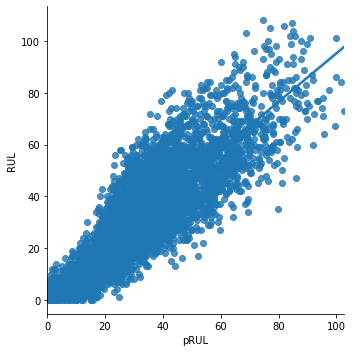

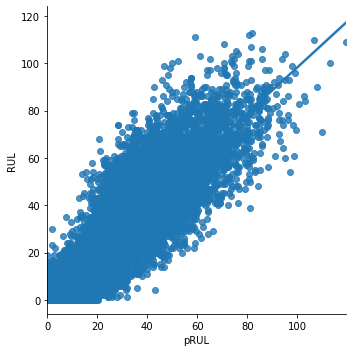

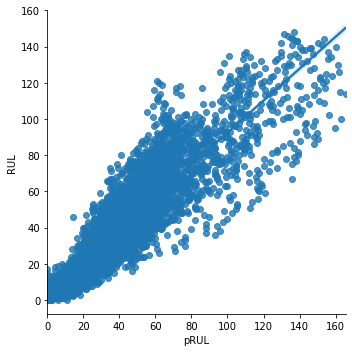

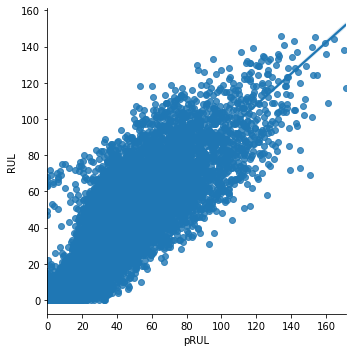

In [109]:
for i in range(4):
    df= fitted_models[i][1][2]
    sns.lmplot(x='pRUL', y= 'RUL', data=df)

In [ ]:
fitted_models[2][2][0]

In [108]:
version=3
for k, v in fitted_models.items():
    name= 'model_'+str(k+1)+'_'+str(version)
    v[0].save(name)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_1_3/assets
INFO:tensorflow:Assets written to: model_2_3/assets
INFO:tensorflow:Assets written to: model_3_3/assets
INFO:tensorflow:Assets written to: model_4_3/assets


In [109]:
for k,v in model_sets.items():
    scal_name= 'scaler_'+str(k+1)+'_'+str(version)+'.joblib'
    feature_name= 'feature_''scaler_'+str(k+1)+'_'+str(version)+'.pickle'
    joblib.dump(v[5], scal_name)
    with open(feature_name, 'wb') as handle:
        pickle.dump(v[6], handle, protocol=pickle.HIGHEST_PROTOCOL)

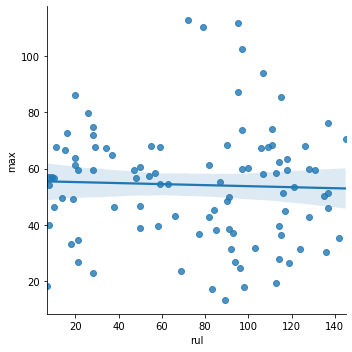

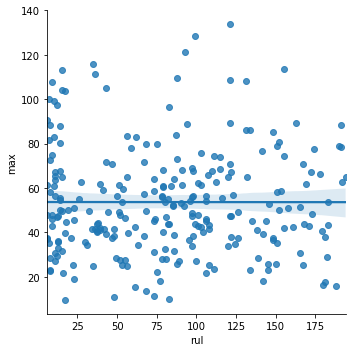

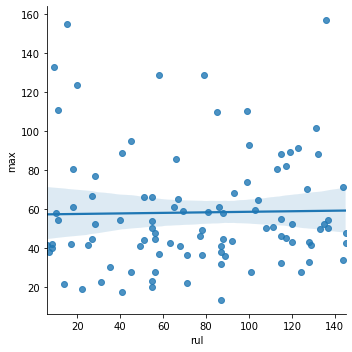

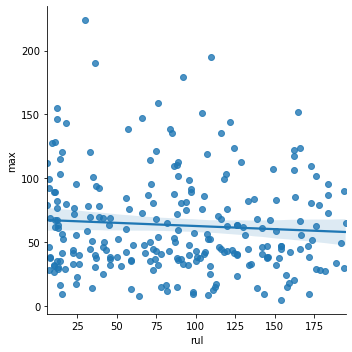

In [110]:
# for k,v in fitted_models.items():
df= v[2][0]
#     sns.lmplot(x='rul', y= 'max', data=df)

In [62]:
RULs[0]

,rul
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59
98,117


In [107]:
for i in range(4):
    df= fitted_models[i][2][0]
    df.reset_index(inplace= True)
    df['unit']= df['unit'].apply(lambda x: i*1000+x)
    

In [80]:
df0= fitted_models[0][2][0]

In [81]:
df= df0.merge(df1, left_index= True, right_index= True)

In [84]:
df['pRUL']= (df.iloc[:,1]- df.iloc[:,0]).apply(lambda x: max(x,0)).apply(lambda x: int(x))

In [85]:
df['pRUL'].describe()

count    100.000000
mean      38.880000
std       15.926143
min       12.000000
25%       27.000000
50%       37.000000
75%       51.000000
max       93.000000
Name: pRUL, dtype: float64

In [92]:
RULs[0]

,rul
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59
98,117
